In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
#from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

#x_train = x_train.reshape((num_train, 28, 28, 1))
#x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (50000, 32, 32, 3)
Step 2 x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0

local = 21

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  50000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
acc, loss = 0, 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기



print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 50000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.6303 - accuracy: 0.4080
16/16 - 0s - loss: 1.6662 - accuracy: 0.4080
16/16 - 0s - loss: 1.6136 - accuracy: 0.3820
16/16 - 0s - loss: 1.6242 - accuracy: 0.4100
16/16 - 0s - loss: 1.5310 - accuracy: 0.4480
16/16 - 0s - loss: 1.6563 - accuracy: 0.3980
16/16 - 0s - loss: 1.5590 - accuracy: 0.4380
16/16 - 0s - loss: 1.7726 - accuracy: 0.3340
16/16 - 0s - loss: 1.5886 - accuracy: 0.4360
16/16 - 0s - loss: 1.7084 - accuracy: 0.4000
16/16 - 0s - loss: 1.7370 - accuracy: 0.3840
16/16 - 0s - loss: 1.6609 - accuracy: 0.3960
16/16 - 0s - loss: 1.5865 - accuracy: 0.4080
16/16 - 0s - loss: 1.6527 - accuracy: 0.3760
16/16 - 0s - loss: 1.7276 - accuracy: 0.3540
16/16 - 0s - loss: 1.6849 - accuracy: 0.3820
16/16 - 0s - loss: 1.6940 - accuracy: 0.3420
16/16 - 0s - loss: 1.5619 - accuracy: 0.4280
16/16 - 0s - loss: 1.6964 - accuracy: 0.3620
16/16 - 0s - loss: 1.6596 - accuracy: 0.4080
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-38bcb3f483de>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        
           
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 50000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.3033 - accuracy: 0.1060
16/16 - 0s - loss: 2.3040 - accuracy: 0.0900
16/16 - 0s - loss: 2.3034 - accuracy: 0.0960
16/16 - 0s - loss: 2.3020 - accuracy: 0.1000
16/16 - 0s - loss: 2.3056 - accuracy: 0.1000
16/16 - 0s - loss: 2.3046 - accuracy: 0.1120
16/16 - 0s - loss: 2.3043 - accuracy: 0.1120
16/16 - 0s - loss: 2.3028 - accuracy: 0.1080
16/16 - 0s - loss: 2.0944 - accuracy: 0.1780
16/16 - 0s - loss: 2.3029 - accuracy: 0.1060
16/16 - 0s - loss: 2.3027 - accuracy: 0.0920
16/16 - 0s - loss: 2.3031 - accuracy: 0.0980
16/16 - 0s - loss: 2.3014 - accuracy: 0.1060
16/16 - 0s - loss: 2.3057 - accuracy: 0.0960
16/16 - 0s - loss: 2.3024 - accuracy: 0.0740
16/16 - 0s - loss: 2.3022 - accuracy: 0.1180
16/16 - 0s - loss: 2.3029 - accuracy: 0.0980
16/16 - 0s - loss: 2.3030 - accuracy: 0.1080
16/16 - 0s - loss: 2.3039 - accuracy: 0.0860
16/16 - 0s - loss: 2.3030 - 

<ipython-input-8-e07fb802303c>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0573 - accuracy: 0.2440
16/16 - 0s - loss: 2.0495 - accuracy: 0.2180
16/16 - 0s - loss: 2.0112 - accuracy: 0.2360
16/16 - 0s - loss: 2.0670 - accuracy: 0.2360
16/16 - 0s - loss: 2.0576 - accuracy: 0.2520
16/16 - 0s - loss: 2.0351 - accuracy: 0.1940
16/16 - 0s - loss: 1.9824 - accuracy: 0.2400
16/16 - 0s - loss: 2.1049 - accuracy: 0.2080
16/16 - 0s - loss: 1.9984 - accuracy: 0.2440
16/16 - 0s - loss: 2.0222 - accuracy: 0.2340
16/16 - 0s - loss: 2.0974 - accuracy: 0.2000
16/16 - 0s - loss: 2.0816 - accuracy: 0.2280
16/16 - 0s - loss: 1.9999 - accuracy: 0.2460
16/16 - 0s - loss: 2.0582 - accuracy: 0.2220
16/16 - 0s - loss: 2.0653 - accuracy: 0.2140
16/16 - 0s - loss: 2.0345 - accuracy: 0.2220
16/16 - 0s - loss: 2.0796 - accuracy: 0.2160
16/16 - 0s - loss: 2.0764 - accuracy: 0.2340
16/16 - 0s - loss: 2.2863 - accuracy: 0.1040
16/16 - 0s - loss: 2.0653 - accuracy: 0.2640
------------    

16/16 - 0s - loss: 1.6566 - accuracy: 0.4120
16/16 - 0s - loss: 1.6860 - accuracy: 0.3820
16/16 - 0s - loss: 1.7122 - accuracy: 0.4140
16/16 - 0s - loss: 1.6231 - accuracy: 0.4200
16/16 - 0s - loss: 1.6753 - accuracy: 0.4120
16/16 - 0s - loss: 1.7546 - accuracy: 0.3680
16/16 - 0s - loss: 1.7740 - accuracy: 0.3720
16/16 - 0s - loss: 1.6828 - accuracy: 0.3940
16/16 - 0s - loss: 1.6505 - accuracy: 0.4060
16/16 - 0s - loss: 1.7389 - accuracy: 0.3800
16/16 - 0s - loss: 1.6636 - accuracy: 0.3780
16/16 - 0s - loss: 1.6957 - accuracy: 0.3860
------------    8  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  142.38385248184204 ---------------------------




====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.6352 - accuracy: 0.4260
16/16 - 0s - los

16/16 - 0s - loss: 1.4361 - accuracy: 0.4940
16/16 - 0s - loss: 1.4049 - accuracy: 0.4980
16/16 - 0s - loss: 1.4888 - accuracy: 0.4920
------------    14  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  159.79234504699707 ---------------------------




====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.4309 - accuracy: 0.4840
16/16 - 0s - loss: 1.4364 - accuracy: 0.4640
16/16 - 0s - loss: 1.4667 - accuracy: 0.4520
16/16 - 0s - loss: 1.4465 - accuracy: 0.4640
16/16 - 0s - loss: 1.4676 - accuracy: 0.4700
16/16 - 0s - loss: 1.4879 - accuracy: 0.4720
16/16 - 0s - loss: 1.4478 - accuracy: 0.4540
16/16 - 0s - loss: 1.4738 - accuracy: 0.4600
16/16 - 0s - loss: 1.4023 - accuracy: 0.5060
16/16 - 0s - loss: 1.4533 - accuracy: 0.4700
16/16 - 0s -

21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.3309 - accuracy: 0.5200
16/16 - 0s - loss: 1.5169 - accuracy: 0.4540
16/16 - 0s - loss: 1.2620 - accuracy: 0.5540
16/16 - 0s - loss: 1.3398 - accuracy: 0.5360
16/16 - 0s - loss: 1.4300 - accuracy: 0.4960
16/16 - 0s - loss: 1.2837 - accuracy: 0.5740
16/16 - 0s - loss: 1.4905 - accuracy: 0.4760
16/16 - 0s - loss: 1.3865 - accuracy: 0.4920
16/16 - 0s - loss: 1.4199 - accuracy: 0.5120
16/16 - 0s - loss: 1.4027 - accuracy: 0.5300
16/16 - 0s - loss: 1.3057 - accuracy: 0.5480
16/16 - 0s - loss: 1.4562 - accuracy: 0.4560
16/16 - 0s - loss: 1.4750 - accuracy: 0.5080
16/16 - 0s - loss: 1.4192 - accuracy: 0.4900
16/16 - 0s - loss: 1.4225 - accuracy: 0.4700
16/16 - 0s - loss: 1.4106 - accuracy: 0.4980
16/16 - 0s - loss: 1.4815 - accuracy: 0.4680
16/16 - 0s - loss: 1.4077 - accuracy: 0.5260
16/16 - 0s - loss: 1.3192 - accuracy: 0.5280
16/16 - 0s - loss: 1.3533 - accuracy: 0.5120
------------  

16/16 - 0s - loss: 1.3979 - accuracy: 0.5400
16/16 - 0s - loss: 1.2690 - accuracy: 0.5620
16/16 - 0s - loss: 1.4463 - accuracy: 0.5040
16/16 - 0s - loss: 1.3207 - accuracy: 0.5440
16/16 - 0s - loss: 1.3673 - accuracy: 0.5180
16/16 - 0s - loss: 1.4909 - accuracy: 0.4800
16/16 - 0s - loss: 1.3807 - accuracy: 0.5340
16/16 - 0s - loss: 1.3846 - accuracy: 0.5380
16/16 - 0s - loss: 1.3245 - accuracy: 0.5500
16/16 - 0s - loss: 1.4212 - accuracy: 0.5120
16/16 - 0s - loss: 1.3581 - accuracy: 0.5000
16/16 - 0s - loss: 1.3158 - accuracy: 0.5080
16/16 - 0s - loss: 1.3268 - accuracy: 0.5680
------------    27  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  279.44969749450684 ---------------------------




====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s -

16/16 - 0s - loss: 1.3897 - accuracy: 0.5240
16/16 - 0s - loss: 1.3817 - accuracy: 0.5520
16/16 - 0s - loss: 1.2465 - accuracy: 0.5760
16/16 - 0s - loss: 1.4414 - accuracy: 0.5180
------------    33  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  334.88220477104187 ---------------------------




====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.3023 - accuracy: 0.5460
16/16 - 0s - loss: 1.3676 - accuracy: 0.5360
16/16 - 0s - loss: 1.4298 - accuracy: 0.5180
16/16 - 0s - loss: 1.3875 - accuracy: 0.4940
16/16 - 0s - loss: 1.3186 - accuracy: 0.5680
16/16 - 0s - loss: 1.4545 - accuracy: 0.5060
16/16 - 0s - loss: 1.2679 - accuracy: 0.5680
16/16 - 0s - loss: 1.3708 - accuracy: 0.5380
16/16 - 0s - loss: 1.3036 - accuracy: 0.6060
16/16 - 0s -

40  번째 global_epoch 데이터 랜덤하게 준비!!
40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.2652 - accuracy: 0.5640
16/16 - 0s - loss: 1.5477 - accuracy: 0.5200
16/16 - 0s - loss: 1.3568 - accuracy: 0.5480
16/16 - 0s - loss: 1.2965 - accuracy: 0.5640
16/16 - 0s - loss: 1.3001 - accuracy: 0.5700
16/16 - 0s - loss: 1.2727 - accuracy: 0.5680
16/16 - 0s - loss: 1.2765 - accuracy: 0.5580
16/16 - 0s - loss: 1.3263 - accuracy: 0.5380
16/16 - 0s - loss: 1.3944 - accuracy: 0.5400
16/16 - 0s - loss: 1.3216 - accuracy: 0.5820
16/16 - 0s - loss: 1.3648 - accuracy: 0.5280
16/16 - 0s - loss: 1.3058 - accuracy: 0.5600
16/16 - 0s - loss: 1.3736 - accuracy: 0.5580
16/16 - 0s - loss: 1.3340 - accuracy: 0.5660
16/16 - 0s - loss: 1.3256 - accuracy: 0.5460
16/16 - 0s - loss: 1.3205 - accuracy: 0.5100
16/16 - 0s - loss: 1.4044 - accuracy: 0.5160
16/16 - 0s - loss: 1.3480 - accuracy: 0.5300
16/16 - 0s - loss: 1.2319 - accuracy: 0.5740
16/16 - 0s - loss: 1.3396

16/16 - 0s - loss: 1.4120 - accuracy: 0.5240
16/16 - 0s - loss: 1.4613 - accuracy: 0.5100
16/16 - 0s - loss: 1.3055 - accuracy: 0.5520
16/16 - 0s - loss: 1.4890 - accuracy: 0.5180
16/16 - 0s - loss: 1.3286 - accuracy: 0.5460
16/16 - 0s - loss: 1.3871 - accuracy: 0.5620
16/16 - 0s - loss: 1.2850 - accuracy: 0.5780
16/16 - 0s - loss: 1.3317 - accuracy: 0.5740
16/16 - 0s - loss: 1.3305 - accuracy: 0.5400
16/16 - 0s - loss: 1.4562 - accuracy: 0.5200
16/16 - 0s - loss: 1.4423 - accuracy: 0.5200
16/16 - 0s - loss: 1.3437 - accuracy: 0.5360
16/16 - 0s - loss: 1.3683 - accuracy: 0.5700
16/16 - 0s - loss: 1.3743 - accuracy: 0.5560
------------    46  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  475.4362885951996 ---------------------------




====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!
47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoc

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[8.8516975e-07, 2.7453718e-06, 0.00038375764, 0.0005326719, 0.0006958713, 0.000830277, 0.0009667102, 0.0011167914, 0.0012693736, 0.0014312727, 0.0015979627, 0.0017696279, 0.0019458433, 0.0021144373, 0.002276776, 0.0024274539, 0.0025907473, 0.0027389387, 0.0028872644, 0.0030432013, 0.0032051227, 0.0033596584, 0.0035272145, 0.0037161196, 0.003897402, 0.0040677967, 0.00425007, 0.0044303965, 0.004616187, 0.004808809, 0.005001226, 0.005201674, 0.005410241, 0.005608137, 0.0058085895, 0.0060064737, 0.006204925, 0.0063962187, 0.0065985643, 0.0068114367, 0.0069998503, 0.0071836803, 0.007363868, 0.0075770975, 0.007785412, 0.007969642, 0.008172151, 0.008356566, 0.0085465]
[4.0872072e-07, 7.5859765e-07, 0.00011592541, 0.00023800155, 0.00048461603, 0.00071183057, 0.0009480857, 0.0011865136, 0.0013892022,

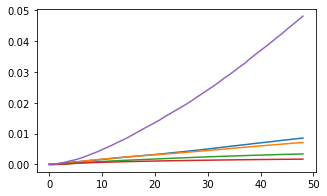

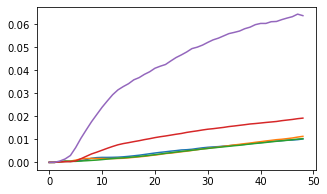

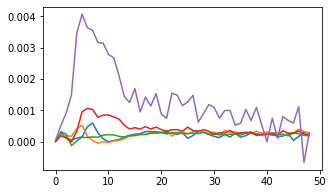

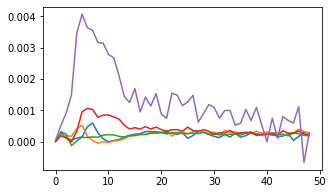

In [9]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.0014734359, 0.017026603, 0.005164121, 0.0054346044, 0.0036228567, 0.004398331, 0.0067470004, 0.0062541817, 0.0035349661, 0.0027447974, 0.003700119, 0.0035020355, 0.0031809425, 0.0028149073, 0.0025305655, 0.0025375139, 0.002218953, 0.0024594462, 0.002266318, 0.0021464762, 0.0020824885, 0.002026593, 0.002257007, 0.0020392512, 0.002147604, 0.0017851033, 0.00200605, 0.0020936162, 0.0021132082, 0.0019262942, 0.001878535, 0.0020073287, 0.0017945372, 0.0017551125, 0.0017914562, 0.0018546706, 0.0016053786, 0.0017876382, 0.0018919682, 0.0015757612, 0.0017274949, 0.0016094836, 0.0013780652, 0.0015685837, 0.0017346941, 0.0014687586, 0.0014420442, 0.001495847, 0.0016470851]
[0.0007840973, 0.008097896, 0.0062762084, 0.009876409, 0.008651278, 0.0068721604, 0.0033033967, 0.0028497297, 0.002763268, 0.002494456, 0.0026645006, 0.0026891849, 0.0029152124, 0.002777263, 0.002792848

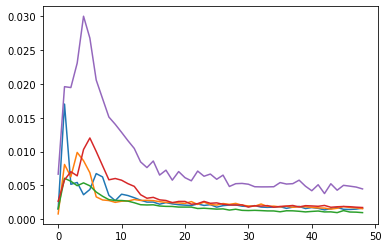

In [10]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.40799999237060547, 0.40799999237060547, 0.38199999928474426, 0.4099999964237213, 0.4480000138282776, 0.39800000190734863, 0.43799999356269836, 0.33399999141693115, 0.4359999895095825, 0.4000000059604645, 0.3840000033378601, 0.3959999978542328, 0.40799999237060547, 0.37599998712539673, 0.3540000021457672, 0.38199999928474426, 0.34200000762939453, 0.42800000309944153, 0.3619999885559082, 0.40799999237060547], [0.10599999874830246, 0.09000000357627869, 0.09600000083446503, 0.10000000149011612, 0.10000000149011612, 0.1120000034570694, 0.1120000034570694, 0.1080000028014183, 0.17800000309944153, 0.10599999874830246, 0.09200000017881393, 0.09799999743700027, 0.10599999874830246, 0.09600000083446503, 0.07400000095367432, 0.11800000071525574, 0.09799999743700027, 0.1080000028014183, 0.0860000029206276, 0.10599999874830246], [0.24400000274181366, 0.21799999

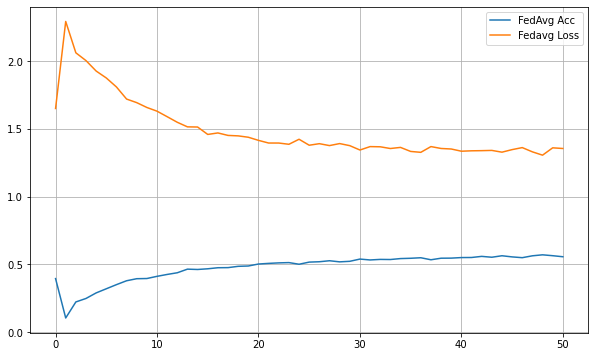

In [11]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')

plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()


In [12]:
average_acc_list[-1], average_loss_list[-1] 

(0.5564000010490417, 1.3553461194038392)